# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

<strong>The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.</strong>

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


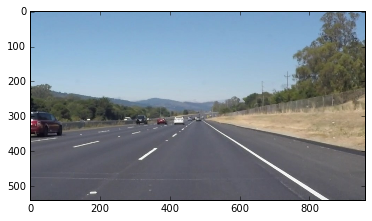

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [43]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, top_coords, extrapolate, y_max, 
               mask=None, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # initialize lists to capture selected left and right coords                
    right_x1_lst = []; right_x2_lst = []
    left_x1_lst = []; left_x2_lst = []
    right_y1_lst = []; right_y2_lst = []
    left_y1_lst = []; left_y2_lst = []
    
    
    for line in lines:
        
        for x1,y1,x2,y2 in line:
            
            if not extrapolate:
                cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
                continue
        
            if np.nan in [x1,x2,y1,y2] or np.inf in [x1,x2,y1,y2]:
                continue
                
            # calculate the slope
            slope = ((y2-y1)/(x2-x1))
            # intercept
            intercept = y1-slope*x1
            
            # new x (will be same formula for right and left)
            left_bot, right_bot = [(y_max-intercept)/slope, y_max], [(y_max-intercept)/slope, y_max]  
                          
            # skip if any of the coordinates not in mask region
            if mask[y1,x1] == 0 or mask[y2,x2] == 0: continue  
            if abs(slope) > 30: continue

            left_top, right_top = top_coords

            # decide lane line location based on slope
            # and filter out any line with a small slope (not vertical enough)
            if slope <= 0:# and slope >= -0.7: # means left lane (y-coords increase going down)
                x2, y2 = left_top
                x1, y1 = left_bot
                left_x1_lst.append(x1)
                left_x2_lst.append(x2)
                left_y1_lst.append(y1)
                left_y2_lst.append(y2)

            elif slope >= 0:# and slope <= 0.7:
                x2, y2 = right_top
                x1, y1 = left_bot
                right_x1_lst.append(x1)
                right_x2_lst.append(x2)
                right_y1_lst.append(y1)
                right_y2_lst.append(y2)

            else: continue
            
            #if len(right_x1_lst) == 0 or len(right_x2_lst) == 0 or len(left_x1_lst) == 0 or len(left_x2_lst) == 0 or \
            #len(right_y1_lst) == 0 or len(right_y2_lst) == 0 or len(left_y1_lst) == 0 or len(left_y2_lst) == 0:
            #    continue
                
    if extrapolate:
        
        right_x1_avg = np.nanmean(right_x1_lst); right_x2_avg = np.nanmean(right_x2_lst)
        left_x1_avg = np.nanmean(left_x1_lst); left_x2_avg = np.nanmean(left_x2_lst)
        right_y1_avg = np.nanmean(right_y1_lst); right_y2_avg = np.nanmean(right_y2_lst)
        left_y1_avg = np.nanmean(left_y1_lst); left_y2_avg = np.nanmean(left_y2_lst)
        
        try:
            cv2.line(img, (int(left_x1_avg), int(left_y1_avg)), 
                 (int(left_x2_avg), int(left_y2_avg)), color, thickness) # left 
            cv2.line(img, (int(right_x1_avg), int(right_y1_avg)), 
                 (int(right_x2_avg), int(right_y2_avg)), color, thickness) # right
                    #cv2.putText(img,str(round(slope,2)), (int(x1),int(y1)), cv2.FONT_ITALIC, 0.4, (0,255,0), thickness=1)
        except:
            return
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, 
                y_max, mask, top_coords=None, extrapolate=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    global lines
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, top_coords, extrapolate, y_max, mask=mask)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [44]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [45]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def lane_detect_pipeline(img, output_dir='test_images_output', save_name=None, 
                         display_images=True, save_final_img=True, extrapolate=True):
    '''
    runs input image (image location) through an image processing pipeline and returns an output image with
    the lane lines identified and marked in red. 
    NOTE: make sure the output_dir already exists in the current directory before running this function
    '''
    
    ## zero step: read-in image and preprocess
    
    # sample image + other stuff    
    if display_images:
        plt.figure()
        plt.imshow(img)
        plt.title('Original Image')
    
    color_img = np.copy(img)
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
    color_channels = color_img.shape[2] # can be 3 or 4
    
    if display_images:
        plt.figure()
        plt.imshow(gray_img, cmap='gray')
        plt.title('Grayscale Image')

    # extract image dims
    yy = color_img.shape[0]
    xx = color_img.shape[1]

    ## first step: find region of interest (automatically)

    # the camera seems to be always situated in the same position in the car
    # hence, we use the same triangle coordinates for ALL images
    # ([bottom_left, bottom_right, top])
    bottom_left, bottom_right, top_left, top_right = [120, yy], [940, yy], [434, 340], [533,340]

    # use a mask on the image
    mask_coords = np.array([bottom_left, bottom_right, top_right, top_left], dtype='int32')
    mask = np.zeros_like(color_img)

    # update mask with triangle region in white
    mask = cv2.fillConvexPoly(mask, mask_coords, (255, )*color_channels)

    # apply bitwise and to original image
    masked_img = cv2.bitwise_and(mask, color_img)
    
    if display_images: # only used for calibration
        plt.figure()
        plt.imshow(masked_img)
        plt.title('Masked Image')
    
    masked_gray_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
    
    global gray_mask
    gray_mask = np.zeros_like(gray_img)
    gray_mask = cv2.fillConvexPoly(gray_mask, mask_coords, 255)

    ## second step: apply canny edge detection and gen. edge image

    # apply gaussian smoothing to supress noise
    gauss_kernel_size = (5,5)
    gauss_img = cv2.GaussianBlur(gray_img, gauss_kernel_size, 0)
    
    if display_images:
        plt.figure()
        plt.imshow(gauss_img, cmap='gray')
        plt.title('Gaussian Blurred Image')

    # find edges in the blurred image using canny
    edge_img = cv2.Canny(gauss_img, 50, 140)
    
    if display_images:
        plt.figure()
        plt.imshow(edge_img, cmap='gray')
        plt.title('Edge Image')
    
    ## third step: find the hough lines in edge image
    lines_img = hough_lines(edge_img, 1, 1*np.pi/180, 30, 5, 7, yy,
                            top_coords=[top_left, top_right], mask=gray_mask, 
                            extrapolate=extrapolate)
    
    if display_images:
        plt.figure()
        plt.imshow(lines_img, cmap='gray')
        plt.title('Lines Image')

    # apply mask to the hough image to remove unnecessary lines
    masked_lines_img = cv2.bitwise_and(mask, lines_img)
    
    #if display_images:
    #    plt.figure()
    #    plt.imshow(masked_lines_img, cmap='gray')
    #    plt.title('Masked Lines Image')

    # fourth step: interlay color hough lines on the original image
    combined_img = cv2.addWeighted(img, 0.8, masked_lines_img, 1, 0)
    
    if display_images:
        plt.figure()
        plt.imshow(combined_img, cmap='gray')
        plt.title('Combined Image')
    
    if save_final_img:
        save_loc =  './'+output_dir + '/' + save_name # need to extract image name from loc
        plt.imsave(save_loc, combined_img)
    
    return combined_img

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figure

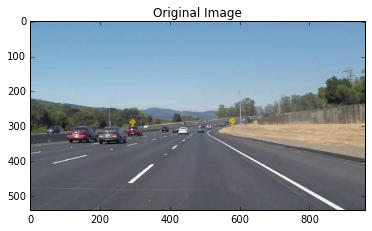

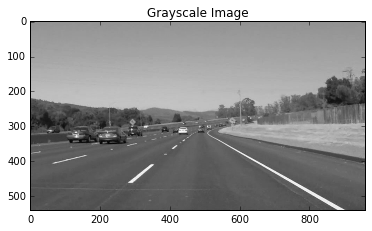

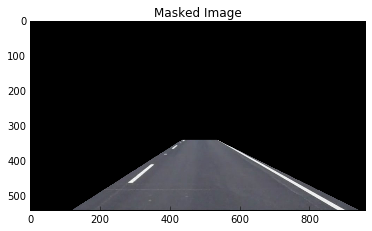

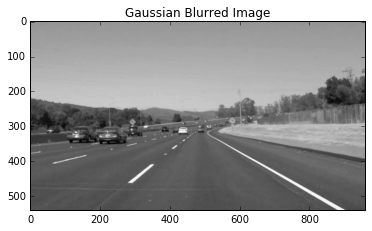

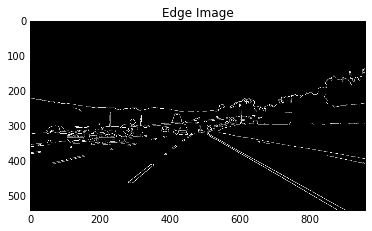

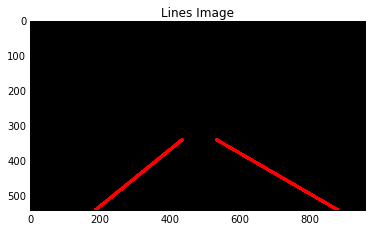

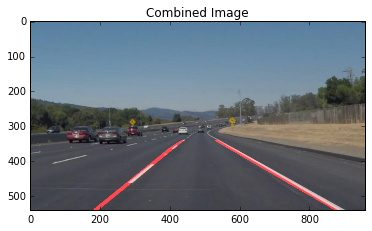

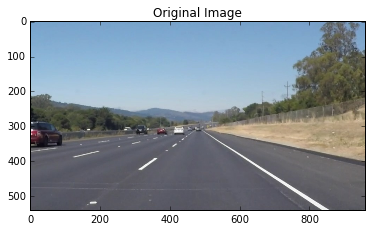

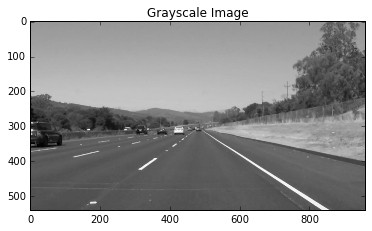

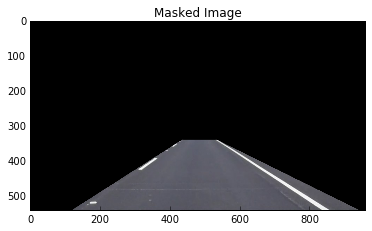

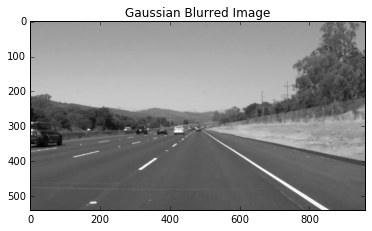

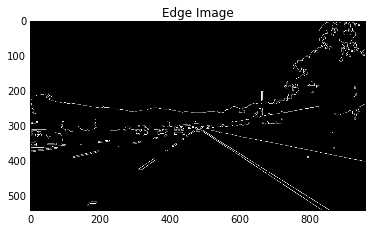

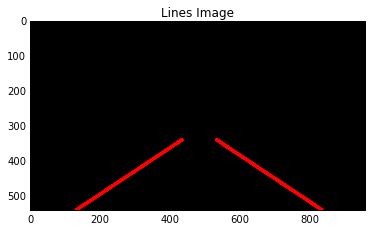

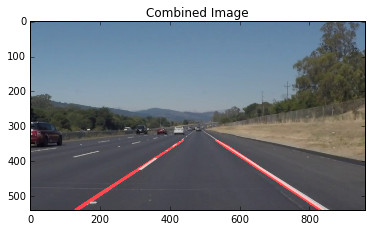

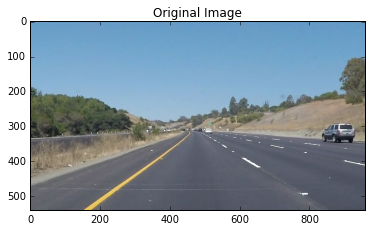

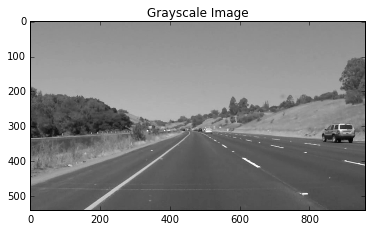

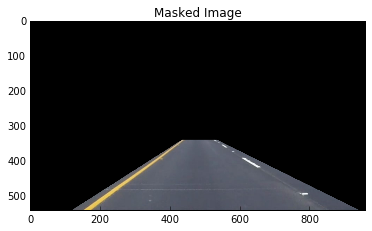

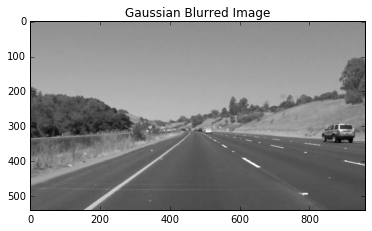

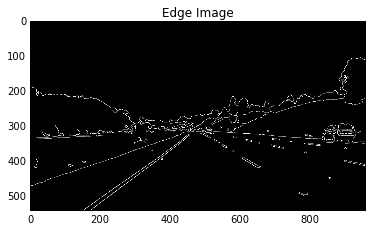

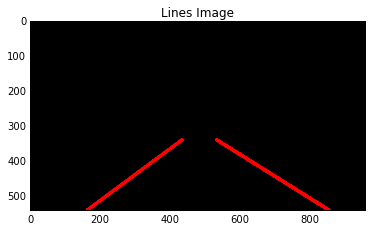

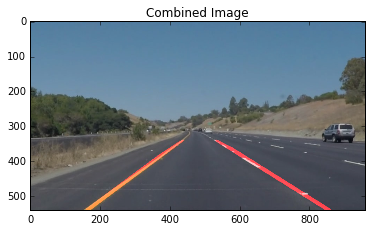

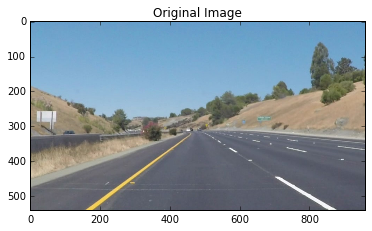

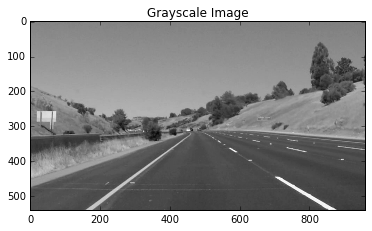

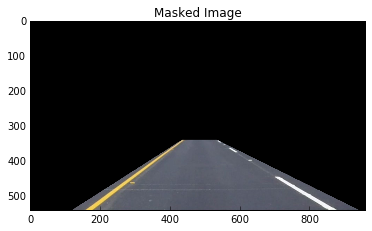

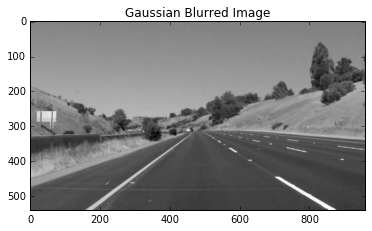

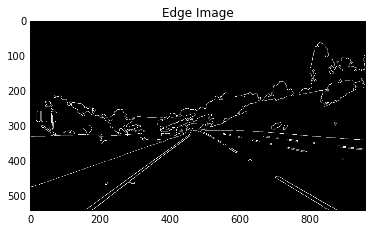

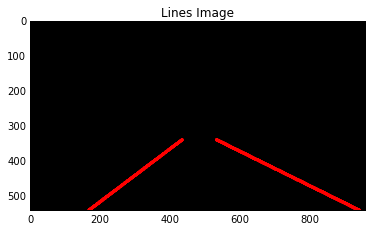

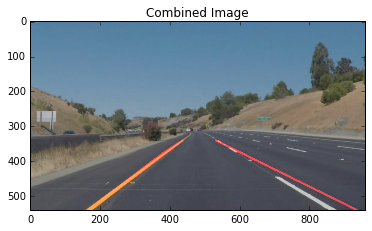

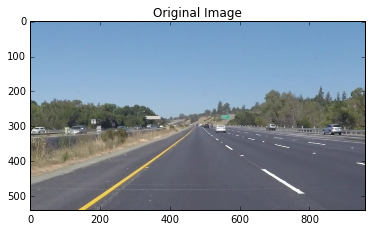

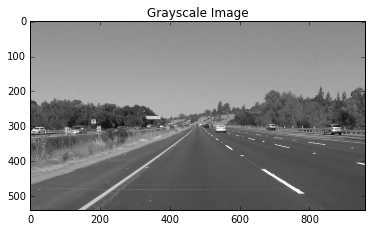

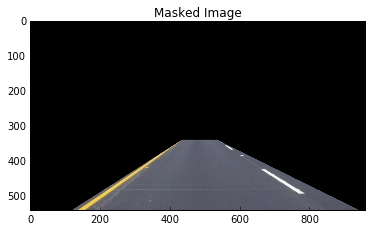

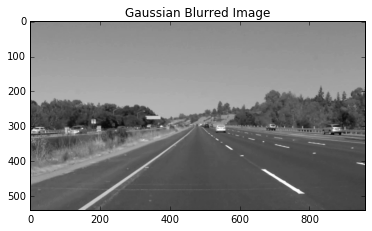

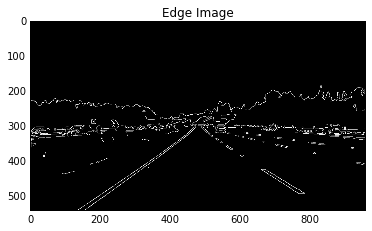

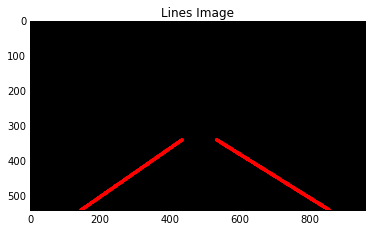

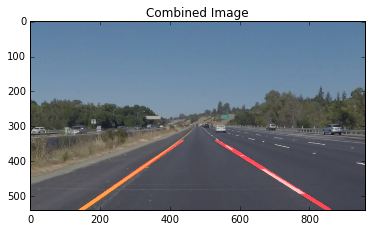

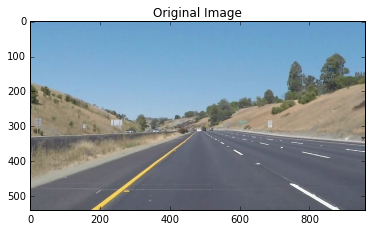

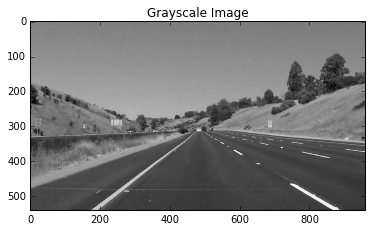

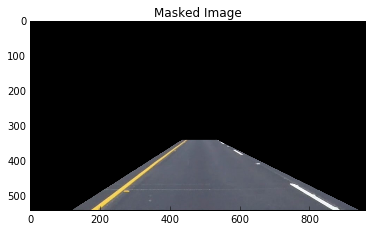

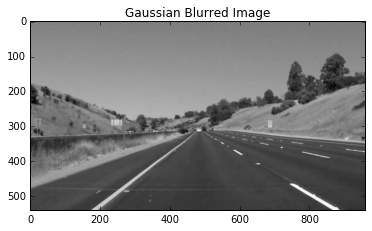

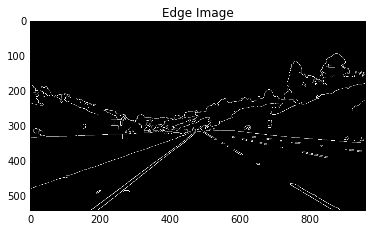

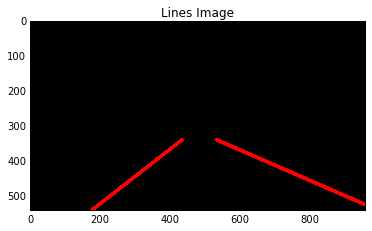

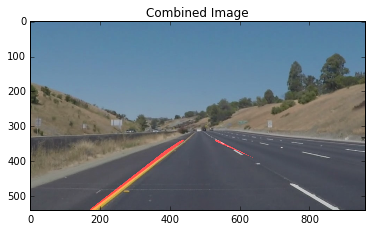

In [46]:
for image in os.listdir("test_images/"):
    
    img_ = plt.imread("test_images/" + image)
    lane_detect_pipeline(img=img_, save_name=image, extrapolate=True)
    

In [57]:
for line in lines: 
    for a,b,c,d in line:
        print(a,b,c,d)
        print((d-b)/(b-a))

612 416 655 413
0.015306122449
248 523 553 447
-0.276363636364
46 458 288 442
-0.0388349514563
420 433 476 430
-0.230769230769
1230 267 1238 265
0.00207684319834
215 434 272 431
-0.013698630137
382 494 511 460
-0.303571428571
312 683 503 534
-0.401617250674
40 455 182 446
-0.021686746988
528 340 536 342
-0.0106382978723
1218 502 1232 504
-0.00279329608939
922 439 1085 456
-0.0351966873706
408 321 422 324
-0.0344827586207
1110 674 1135 674
-0.0
1 444 95 441
-0.00677200902935
485 426 614 417
0.152542372881
285 684 546 495
-0.473684210526
856 433 861 434
-0.00236406619385
911 440 982 448
-0.0169851380042
973 438 980 438
-0.0
1050 417 1070 419
-0.00315955766193
603 667 787 667
0.0
142 260 176 268
0.0677966101695
1187 390 1214 389
0.00125470514429
190 428 205 428
0.0
91 575 233 536
-0.0805785123967
981 439 1097 449
-0.0184501845018
834 429 840 430
-0.00246913580247
127 438 165 438
0.0
1062 401 1076 403
-0.00302571860817
509 334 533 339
-0.0285714285714
1 587 161 545
-0.0716723549488
141 309

In [48]:
gray_mask.shape


(540, 960)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [49]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return lane_detect_pipeline(img=image, display_images=False, save_final_img=False)

Let's try the one with the solid white lane on the right first ...

In [51]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

//anaconda/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file test_videos_output/solidWhiteRight.mp4
----------------------------------------

Writing video into test_videos_output/solidWhiteRight.mp4


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|----------| 0/213   0% [elapsed: 00:00 left: ?, ? iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|----------| 2/213   0% [elapsed: 00:00 left: 00:57,  3.66 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|----------| 4/213   1% [elapsed: 00:01 left: 00:57,  3.63 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 9/213   4% [elapsed: 00:01 left: 00:36,  5.57 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 18/213   8% [elapsed: 00:02 left: 00:23,  8.45 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 25/213  11% [elapsed: 00:02 left: 00:22,  8.47 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#---------| 29/213  13% [elapsed: 00:03 left: 00:22,  8.17 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#---------| 34/213  15% [elapsed: 00:04 left: 00:22,  8.06 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 43/213  20% [elapsed: 00:04 left: 00:18,  8.98 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 50/213  23% [elapsed: 00:05 left: 00:17,  9.37 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 56/213  26% [elapsed: 00:05 left: 00:16,  9.53 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 62/213  29% [elapsed: 00:06 left: 00:15,  9.69 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 71/213  33% [elapsed: 00:06 left: 00:13, 10.26 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 81/213  38% [elapsed: 00:07 left: 00:12, 10.84 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|####------| 90/213  42% [elapsed: 00:08 left: 00:10, 11.23 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|####------| 99/213  46% [elapsed: 00:08 left: 00:09, 11.56 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#####-----| 109/213  51% [elapsed: 00:09 left: 00:08, 11.95 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#####-----| 119/213  55% [elapsed: 00:09 left: 00:07, 12.26 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#####-----| 126/213  59% [elapsed: 00:10 left: 00:07, 12.31 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 134/213  62% [elapsed: 00:10 left: 00:06, 12.36 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|######----| 142/213  66% [elapsed: 00:11 left: 00:05, 12.46 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 150/213  70% [elapsed: 00:11 left: 00:05, 12.58 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 159/213  74% [elapsed: 00:12 left: 00:04, 12.74 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#######---| 168/213  78% [elapsed: 00:12 left: 00:03, 12.92 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars

|########--| 178/213  83% [elapsed: 00:13 left: 00:02, 13.16 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|########--| 188/213  88% [elapsed: 00:14 left: 00:01, 13.40 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#########-| 198/213  92% [elapsed: 00:14 left: 00:01, 13.61 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#########-| 206/213  96% [elapsed: 00:15 left: 00:00, 13.66 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

Done writing video in test_videos_output/solidWhiteRight.mp4 !
Your video is ready !
CPU times: user 10.3 s, sys: 1.74 s, total: 12.1 s
Wall time: 16.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [53]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


MoviePy: building video file test_videos_output/solidYellowLeft.mp4
----------------------------------------

Writing video into test_videos_output/solidYellowLeft.mp4
|----------| 0/654   0% [elapsed: 00:00 left: ?, ? iters/sec]

//anaconda/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykerne

|----------| 5/654   0% [elapsed: 00:00 left: 01:07,  9.65 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars

|----------| 13/654   1% [elapsed: 00:01 left: 00:51, 12.45 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 22/654   3% [elapsed: 00:01 left: 00:44, 14.05 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 31/654   4% [elapsed: 00:02 left: 00:42, 14.52 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|----------| 40/654   6% [elapsed: 00:02 left: 00:41, 14.94 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 49/654   7% [elapsed: 00:03 left: 00:40, 15.09 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|----------| 53/654   8% [elapsed: 00:03 left: 00:43, 13.94 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_

|----------| 61/654   9% [elapsed: 00:04 left: 00:42, 14.05 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 68/654  10% [elapsed: 00:04 left: 00:41, 14.05 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|#---------| 76/654  11% [elapsed: 00:05 left: 00:41, 14.04 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 83/654  12% [elapsed: 00:05 left: 00:41, 13.87 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_

|#---------| 90/654  13% [elapsed: 00:06 left: 00:41, 13.70 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 96/654  14% [elapsed: 00:07 left: 00:41, 13.54 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|#---------| 102/654  15% [elapsed: 00:07 left: 00:42, 13.12 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 105/654  16% [elapsed: 00:08 left: 00:43, 12.58 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 108/654  16% [elapsed: 00:08 left: 00:44, 12.18 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 112/654  17% [elapsed: 00:09 left: 00:45, 11.89 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 116/654  17% [elapsed: 00:09 left: 00:46, 11.62 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 121/654  18% [elapsed: 00:10 left: 00:46, 11.48 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#---------| 125/654  19% [elapsed: 00:11 left: 00:46, 11.31 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|##--------| 133/654  20% [elapsed: 00:12 left: 00:47, 10.97 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|##--------| 140/654  21% [elapsed: 00:12 left: 00:46, 11.08 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|##--------| 147/654  22% [elapsed: 00:13 left: 00:45, 11.19 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|##--------| 156/654  23% [elapsed: 00:13 left: 00:43, 11.43 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|##--------| 166/654  25% [elapsed: 00:14 left: 00:41, 11.69 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 176/654  26% [elapsed: 00:14 left: 00:40, 11.95 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 186/654  28% [elapsed: 00:15 left: 00:38, 12.19 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//an

|##--------| 196/654  29% [elapsed: 00:15 left: 00:36, 12.41 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 204/654  31% [elapsed: 00:16 left: 00:35, 12.52 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 213/654  32% [elapsed: 00:16 left: 00:34, 12.66 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 221/654  33% [elapsed: 00:17 left: 00:34, 12.71 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 228/654  34% [elapsed: 00:17 left: 00:33, 12.74 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 236/654  36% [elapsed: 00:18 left: 00:32, 12.80 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 244/654  37% [elapsed: 00:18 left: 00:31, 12.85 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|###-------| 252/654  38% [elapsed: 00:19 left: 00:31, 12.93 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|###-------| 260/654  39% [elapsed: 00:20 left: 00:30, 12.97 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|####------| 267/654  40% [elapsed: 00:20 left: 00:29, 12.97 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|####------| 274/654  41% [elapsed: 00:21 left: 00:29, 12.99 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|####------| 282/654  43% [elapsed: 00:21 left: 00:28, 13.01 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|####------| 290/654  44% [elapsed: 00:22 left: 00:27, 13.05 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|####------| 296/654  45% [elapsed: 00:22 left: 00:27, 13.00 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars

|####------| 303/654  46% [elapsed: 00:23 left: 00:26, 13.02 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|####------| 308/654  47% [elapsed: 00:23 left: 00:26, 12.93 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|####------| 313/654  47% [elapsed: 00:24 left: 00:26, 12.84 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|####------| 319/654  48% [elapsed: 00:24 left: 00:26, 12.79 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|####------| 326/654  49% [elapsed: 00:25 left: 00:25, 12.80 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#####-----| 331/654  50% [elapsed: 00:26 left: 00:25, 12.71 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#####-----| 336/654  51% [elapsed: 00:26 left: 00:25, 12.63 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#####-----| 341/654  52% [elapsed: 00:27 left: 00:24, 12.57 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#####-----| 348/654  53% [elapsed: 00:27 left: 00:24, 12.58 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#####-----| 356/654  54% [elapsed: 00:28 left: 00:23, 12.63 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_

|#####-----| 364/654  55% [elapsed: 00:28 left: 00:22, 12.69 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_

|#####-----| 369/654  56% [elapsed: 00:29 left: 00:22, 12.63 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#####-----| 374/654  57% [elapsed: 00:29 left: 00:22, 12.56 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#####-----| 379/654  57% [elapsed: 00:30 left: 00:21, 12.51 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#####-----| 385/654  58% [elapsed: 00:30 left: 00:21, 12.49 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|#####-----| 391/654  59% [elapsed: 00:31 left: 00:21, 12.46 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 395/654  60% [elapsed: 00:31 left: 00:20, 12.38 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|######----| 402/654  61% [elapsed: 00:32 left: 00:20, 12.38 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 408/654  62% [elapsed: 00:32 left: 00:19, 12.38 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 414/654  63% [elapsed: 00:33 left: 00:19, 12.34 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 420/654  64% [elapsed: 00:34 left: 00:18, 12.33 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 426/654  65% [elapsed: 00:34 left: 00:18, 12.32 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars

|######----| 431/654  65% [elapsed: 00:35 left: 00:18, 12.27 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 436/654  66% [elapsed: 00:35 left: 00:17, 12.20 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 441/654  67% [elapsed: 00:36 left: 00:17, 12.15 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|######----| 448/654  68% [elapsed: 00:36 left: 00:16, 12.16 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|######----| 454/654  69% [elapsed: 00:37 left: 00:16, 12.15 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#######---| 459/654  70% [elapsed: 00:37 left: 00:16, 12.10 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#######---| 464/654  70% [elapsed: 00:38 left: 00:15, 12.06 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#######---| 469/654  71% [elapsed: 00:39 left: 00:15, 12.02 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#######---| 474/654  72% [elapsed: 00:39 left: 00:15, 11.97 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#######---| 479/654  73% [elapsed: 00:40 left: 00:14, 11.92 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|#######---| 485/654  74% [elapsed: 00:40 left: 00:14, 11.90 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#######---| 489/654  74% [elapsed: 00:41 left: 00:13, 11.84 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#######---| 492/654  75% [elapsed: 00:41 left: 00:13, 11.77 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#######---| 496/654  75% [elapsed: 00:42 left: 00:13, 11.72 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#######---| 500/654  76% [elapsed: 00:42 left: 00:13, 11.66 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 504/654  77% [elapsed: 00:43 left: 00:12, 11.56 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#######---| 506/654  77% [elapsed: 00:44 left: 00:12, 11.44 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#######---| 508/654  77% [elapsed: 00:44 left: 00:12, 11.36 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#######---| 511/654  78% [elapsed: 00:45 left: 00:12, 11.22 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 514/654  78% [elapsed: 00:46 left: 00:12, 11.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 517/654  79% [elapsed: 00:46 left: 00:12, 11.06 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//an

|#######---| 522/654  79% [elapsed: 00:47 left: 00:11, 11.03 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|########--| 526/654  80% [elapsed: 00:47 left: 00:11, 10.97 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|########--| 529/654  80% [elapsed: 00:48 left: 00:11, 10.92 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|########--| 537/654  82% [elapsed: 00:48 left: 00:10, 10.96 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|########--| 543/654  83% [elapsed: 00:49 left: 00:10, 10.97 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|########--| 550/654  84% [elapsed: 00:50 left: 00:09, 10.99 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|########--| 556/654  85% [elapsed: 00:50 left: 00:08, 10.99 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|########--| 562/654  85% [elapsed: 00:51 left: 00:08, 11.00 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|########--| 568/654  86% [elapsed: 00:51 left: 00:07, 10.99 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|########--| 574/654  87% [elapsed: 00:52 left: 00:07, 10.99 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|########--| 579/654  88% [elapsed: 00:52 left: 00:06, 10.97 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|########--| 587/654  89% [elapsed: 00:53 left: 00:06, 11.01 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars

|#########-| 593/654  90% [elapsed: 00:53 left: 00:05, 11.02 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#########-| 599/654  91% [elapsed: 00:54 left: 00:04, 11.02 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars

|#########-| 605/654  92% [elapsed: 00:54 left: 00:04, 11.03 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#########-| 611/654  93% [elapsed: 00:55 left: 00:03, 11.04 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scal

|#########-| 619/654  94% [elapsed: 00:55 left: 00:03, 11.07 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#########-| 627/654  95% [elapsed: 00:56 left: 00:02, 11.11 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#########-| 635/654  97% [elapsed: 00:57 left: 00:01, 11.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#########-| 641/654  98% [elapsed: 00:57 left: 00:01, 11.14 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#########-| 647/654  98% [elapsed: 00:58 left: 00:00, 11.11 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|#########-| 651/654  99% [elapsed: 00:58 left: 00:00, 11.07 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


Done writing video in test_videos_output/solidYellowLeft.mp4 !
Your video is ready !
CPU times: user 38.8 s, sys: 5.61 s, total: 44.4 s
Wall time: 1min


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [55]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


MoviePy: building video file test_videos_output/challenge.mp4
----------------------------------------

Writing video into test_videos_output/challenge.mp4
|----------| 0/241   0% [elapsed: 00:00 left: ?, ? iters/sec]

//anaconda/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykerne

|----------| 4/241   1% [elapsed: 00:00 left: 00:33,  6.98 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 8/241   3% [elapsed: 00:01 left: 00:34,  6.74 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 12/241   4% [elapsed: 00:01 left: 00:34,  6.65 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 15/241   6% [elapsed: 00:02 left: 00:37,  6.10 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 18/241   7% [elapsed: 00:03 left: 00:38,  5.76 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|----------| 20/241   8% [elapsed: 00:03 left: 00:40,  5.51 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|----------| 23/241   9% [elapsed: 00:04 left: 00:41,  5.27 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#---------| 25/241  10% [elapsed: 00:04 left: 00:42,  5.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#---------| 28/241  11% [elapsed: 00:05 left: 00:41,  5.15 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#---------| 32/241  13% [elapsed: 00:05 left: 00:39,  5.34 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#---------| 36/241  14% [elapsed: 00:06 left: 00:37,  5.48 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#---------| 39/241  16% [elapsed: 00:07 left: 00:37,  5.41 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//an

|#---------| 42/241  17% [elapsed: 00:07 left: 00:36,  5.44 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#---------| 45/241  18% [elapsed: 00:08 left: 00:35,  5.44 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 49/241  20% [elapsed: 00:08 left: 00:34,  5.51 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 53/241  21% [elapsed: 00:09 left: 00:33,  5.56 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 57/241  23% [elapsed: 00:10 left: 00:32,  5.60 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|##--------| 60/241  24% [elapsed: 00:10 left: 00:32,  5.60 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//an

|##--------| 63/241  26% [elapsed: 00:11 left: 00:31,  5.57 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//an

|##--------| 66/241  27% [elapsed: 00:11 left: 00:31,  5.55 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|##--------| 69/241  28% [elapsed: 00:12 left: 00:31,  5.48 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|##--------| 71/241  29% [elapsed: 00:13 left: 00:31,  5.41 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 73/241  30% [elapsed: 00:13 left: 00:31,  5.29 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 75/241  31% [elapsed: 00:14 left: 00:32,  5.15 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 77/241  31% [elapsed: 00:15 left: 00:32,  5.02 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 79/241  32% [elapsed: 00:16 left: 00:33,  4.84 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 80/241  33% [elapsed: 00:16 left: 00:33,  4.74 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 82/241  34% [elapsed: 00:17 left: 00:34,  4.56 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 83/241  34% [elapsed: 00:18 left: 00:35,  4.46 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 84/241  34% [elapsed: 00:19 left: 00:35,  4.39 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 86/241  35% [elapsed: 00:20 left: 00:36,  4.27 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 88/241  36% [elapsed: 00:20 left: 00:36,  4.21 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 90/241  37% [elapsed: 00:21 left: 00:36,  4.17 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|###-------| 92/241  38% [elapsed: 00:22 left: 00:36,  4.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|###-------| 95/241  39% [elapsed: 00:22 left: 00:35,  4.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars


|####------| 98/241  40% [elapsed: 00:23 left: 00:34,  4.15 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//an

|####------| 101/241  41% [elapsed: 00:24 left: 00:33,  4.14 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|####------| 103/241  42% [elapsed: 00:24 left: 00:33,  4.14 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|####------| 106/241  43% [elapsed: 00:25 left: 00:32,  4.15 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|####------| 108/241  44% [elapsed: 00:26 left: 00:32,  4.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|####------| 111/241  46% [elapsed: 00:26 left: 00:31,  4.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//an

|####------| 114/241  47% [elapsed: 00:27 left: 00:30,  4.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|####------| 116/241  48% [elapsed: 00:28 left: 00:30,  4.13 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|####------| 118/241  48% [elapsed: 00:28 left: 00:29,  4.12 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#####-----| 121/241  50% [elapsed: 00:29 left: 00:29,  4.12 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 123/241  51% [elapsed: 00:29 left: 00:28,  4.10 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 125/241  51% [elapsed: 00:30 left: 00:28,  4.08 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 127/241  52% [elapsed: 00:31 left: 00:28,  4.06 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 129/241  53% [elapsed: 00:31 left: 00:27,  4.03 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 131/241  54% [elapsed: 00:32 left: 00:27,  4.01 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#####-----| 133/241  55% [elapsed: 00:33 left: 00:27,  3.95 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 135/241  56% [elapsed: 00:35 left: 00:27,  3.85 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 136/241  56% [elapsed: 00:35 left: 00:27,  3.80 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 137/241  56% [elapsed: 00:36 left: 00:28,  3.71 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 138/241  57% [elapsed: 00:38 left: 00:28,  3.63 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 139/241  57% [elapsed: 00:38 left: 00:28,  3.58 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 140/241  58% [elapsed: 00:39 left: 00:28,  3.54 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 141/241  58% [elapsed: 00:40 left: 00:28,  3.47 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 142/241  58% [elapsed: 00:41 left: 00:28,  3.43 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#####-----| 144/241  59% [elapsed: 00:42 left: 00:28,  3.37 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|######----| 146/241  60% [elapsed: 00:43 left: 00:28,  3.33 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|######----| 148/241  61% [elapsed: 00:44 left: 00:27,  3.32 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|######----| 151/241  62% [elapsed: 00:45 left: 00:26,  3.34 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|######----| 154/241  63% [elapsed: 00:45 left: 00:25,  3.36 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|######----| 156/241  64% [elapsed: 00:46 left: 00:25,  3.35 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|######----| 158/241  65% [elapsed: 00:47 left: 00:24,  3.36 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|######----| 161/241  66% [elapsed: 00:47 left: 00:23,  3.37 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|######----| 164/241  68% [elapsed: 00:48 left: 00:22,  3.38 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|######----| 167/241  69% [elapsed: 00:49 left: 00:21,  3.40 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#######---| 170/241  70% [elapsed: 00:49 left: 00:20,  3.42 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 174/241  72% [elapsed: 00:50 left: 00:19,  3.46 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 178/241  73% [elapsed: 00:50 left: 00:18,  3.49 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 182/241  75% [elapsed: 00:51 left: 00:16,  3.53 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 185/241  76% [elapsed: 00:52 left: 00:15,  3.53 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#######---| 188/241  78% [elapsed: 00:52 left: 00:14,  3.55 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#######---| 192/241  79% [elapsed: 00:53 left: 00:13,  3.58 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|########--| 196/241  81% [elapsed: 00:54 left: 00:12,  3.62 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|########--| 199/241  82% [elapsed: 00:54 left: 00:11,  3.63 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|########--| 202/241  83% [elapsed: 00:55 left: 00:10,  3.65 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|########--| 205/241  85% [elapsed: 00:55 left: 00:09,  3.67 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|########--| 207/241  85% [elapsed: 00:56 left: 00:09,  3.66 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|########--| 210/241  87% [elapsed: 00:57 left: 00:08,  3.67 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|########--| 213/241  88% [elapsed: 00:57 left: 00:07,  3.69 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|########--| 216/241  89% [elapsed: 00:58 left: 00:06,  3.69 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 218/241  90% [elapsed: 00:59 left: 00:06,  3.67 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 220/241  91% [elapsed: 01:00 left: 00:05,  3.65 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 221/241  91% [elapsed: 01:00 left: 00:05,  3.64 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 223/241  92% [elapsed: 01:01 left: 00:04,  3.63 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 225/241  93% [elapsed: 01:02 left: 00:04,  3.62 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 227/241  94% [elapsed: 01:02 left: 00:03,  3.62 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 229/241  95% [elapsed: 01:03 left: 00:03,  3.62 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#########-| 232/241  96% [elapsed: 01:03 left: 00:02,  3.63 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//a

|#########-| 234/241  97% [elapsed: 01:05 left: 00:01,  3.60 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 235/241  97% [elapsed: 01:05 left: 00:01,  3.57 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 237/241  98% [elapsed: 01:06 left: 00:01,  3.55 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


|#########-| 239/241  99% [elapsed: 01:08 left: 00:00,  3.51 iters/sec]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in int_scalars
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


Done writing video in test_videos_output/challenge.mp4 !
Your video is ready !
CPU times: user 49.1 s, sys: 4.18 s, total: 53.3 s
Wall time: 1min 12s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))